In [25]:
! wget https://heasarc.gsfc.nasa.gov/FTP/fermi/data/gbm/triggers/2025/bn250313607/quicklook/glg_healpix_all_bn250313607.fit

--2025-05-08 16:13:31--  https://heasarc.gsfc.nasa.gov/FTP/fermi/data/gbm/triggers/2025/bn250313607/quicklook/glg_healpix_all_bn250313607.fit
Resolving heasarc.gsfc.nasa.gov (heasarc.gsfc.nasa.gov)... 129.164.179.23
Connecting to heasarc.gsfc.nasa.gov (heasarc.gsfc.nasa.gov)|129.164.179.23|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1586880 (1.5M) [application/fits]
Saving to: ‘glg_healpix_all_bn250313607.fit’

glg_healpix_all_bn2 100%[===================>]   1.51M   477KB/s    in 3.2s    

2025-05-08 16:13:36 (477 KB/s) - ‘glg_healpix_all_bn250313607.fit’ saved [1586880/1586880]



/var/folders/ws/0948zvwd7g795j2l3fryghjw0000gp/T/ipykernel_23800/615461525.py:11: HealpyDeprecationWarning: "verbose" was deprecated in version 1.15.0 and will be removed in a future version. 
  map_data = hp.read_map(filename, nest=False, verbose=False)


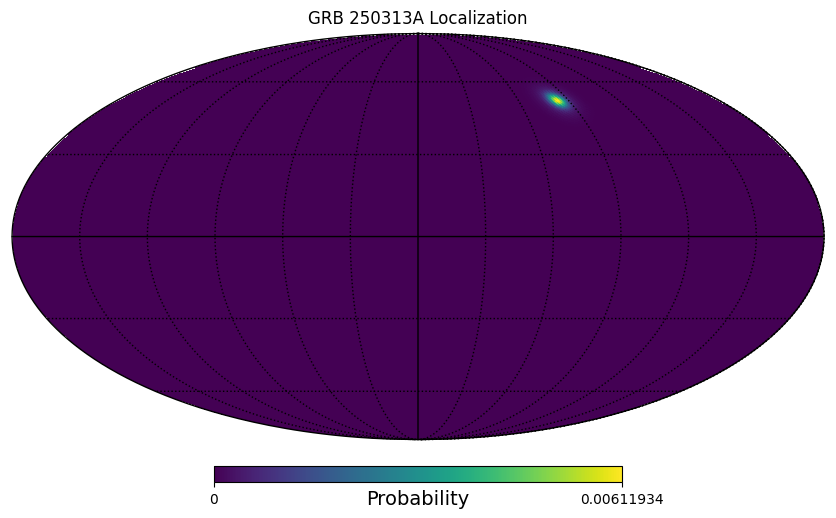

In [1]:
import healpy as hp
import matplotlib.pyplot as plt
from astropy.io import fits

# Path to the downloaded FITS file
filename = 'glg_healpix_all_bn250313607.fit'

# Read the HEALPix map
# Assuming the data is in the first extension (extension=1)
# Adjust 'nest' parameter based on the FITS header information
map_data = hp.read_map(filename, nest=False, verbose=False)

# Plot the sky map using Mollweide projection
hp.mollview(map_data, title='GRB 250313A Localization', unit='Probability', cmap='viridis')
hp.graticule()
plt.show()

## Creating KDE

In [2]:
import healpy as hp
import numpy as np
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord
from scipy.stats import gaussian_kde

# Load HEALPix data
filename = 'glg_healpix_all_bn250313607.fit'
map_data = hp.read_map(filename, nest=False, verbose=False)

# Get indices of HEALPix pixels
nside = hp.get_nside(map_data)
indices = np.arange(len(map_data))

# Convert indices to RA and Dec
theta, phi = hp.pix2ang(nside, indices)
ra = np.degrees(phi)
dec = np.degrees(0.5 * np.pi - theta)

# Normalize probabilities (for KDE weights)
probabilities = map_data / np.sum(map_data)

# Select significant pixels (e.g., above a certain threshold to reduce noise)
threshold = np.percentile(probabilities, 90)
significant = probabilities > threshold
ra_sig = ra[significant]
dec_sig = dec[significant]
weights_sig = probabilities[significant]

# Create a 2D Gaussian KDE
coords = np.vstack([ra_sig, dec_sig])
kde = gaussian_kde(coords, weights=weights_sig)

# Generate a grid for evaluation
ra_grid, dec_grid = np.mgrid[0:360:360j, -90:90:180j]
grid_coords = np.vstack([ra_grid.ravel(), dec_grid.ravel()])

# Evaluate KDE on the grid
density = kde(grid_coords).reshape(ra_grid.shape)

/var/folders/ws/0948zvwd7g795j2l3fryghjw0000gp/T/ipykernel_23800/1277915969.py:9: HealpyDeprecationWarning: "verbose" was deprecated in version 1.15.0 and will be removed in a future version. 
  map_data = hp.read_map(filename, nest=False, verbose=False)


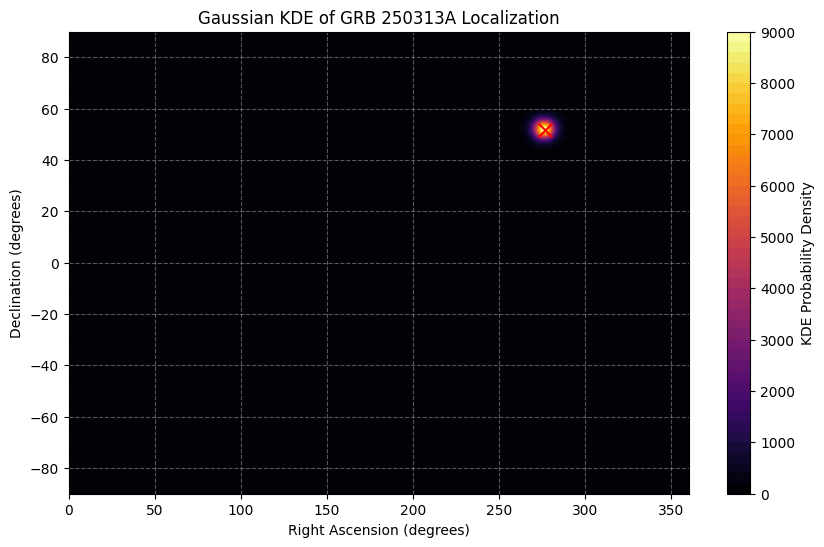

In [7]:
# Plotting the KDE as a contour map
plt.figure(figsize=(10, 6))
plt.contourf(ra_grid, dec_grid, density, cmap='inferno', levels=50)
plt.colorbar(label='KDE Probability Density')
# add the scatter plot of RA = 276.4, Dec = 51.8
plt.scatter(276.4, 51.8, color='red', marker='x', s=100, label='GRB 250313A Position')
plt.xlabel('Right Ascension (degrees)')
plt.ylabel('Declination (degrees)')
plt.title('Gaussian KDE of GRB 250313A Localization')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


## KDE with weighting (coversion from 3D to 2D map)

In [11]:
import healpy as hp
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# Load HEALPix data
filename = 'glg_healpix_all_bn250313607.fit'
map_data = hp.read_map(filename, nest=False, verbose=False)

# Pixel indices
nside = hp.get_nside(map_data)
indices = np.arange(len(map_data))

# Convert to spherical angles
theta, phi = hp.pix2ang(nside, indices)

# Cartesian coordinates on the unit sphere
x = np.sin(theta) * np.cos(phi)
y = np.sin(theta) * np.sin(phi)
z = np.cos(theta)

# Normalize probabilities
probabilities = map_data / np.sum(map_data)

# Select significant pixels
threshold = np.percentile(probabilities, 90)
significant = probabilities > threshold
coords_3d = np.vstack([x[significant], y[significant], z[significant]])
weights_sig = probabilities[significant]

# Gaussian KDE in 3D
kde = gaussian_kde(coords_3d, weights=weights_sig)

# Evaluate KDE on a grid (RA-Dec grid)
ra_grid, dec_grid = np.mgrid[0:360:360j, -90:90:180j]
phi_grid = np.radians(ra_grid)
theta_grid = np.radians(90 - dec_grid)

xg = np.sin(theta_grid) * np.cos(phi_grid)
yg = np.sin(theta_grid) * np.sin(phi_grid)
zg = np.cos(theta_grid)
grid_3d = np.vstack([xg.ravel(), yg.ravel(), zg.ravel()])

density = kde(grid_3d).reshape(ra_grid.shape)

/var/folders/ws/0948zvwd7g795j2l3fryghjw0000gp/T/ipykernel_23800/3117399662.py:8: HealpyDeprecationWarning: "verbose" was deprecated in version 1.15.0 and will be removed in a future version. 
  map_data = hp.read_map(filename, nest=False, verbose=False)


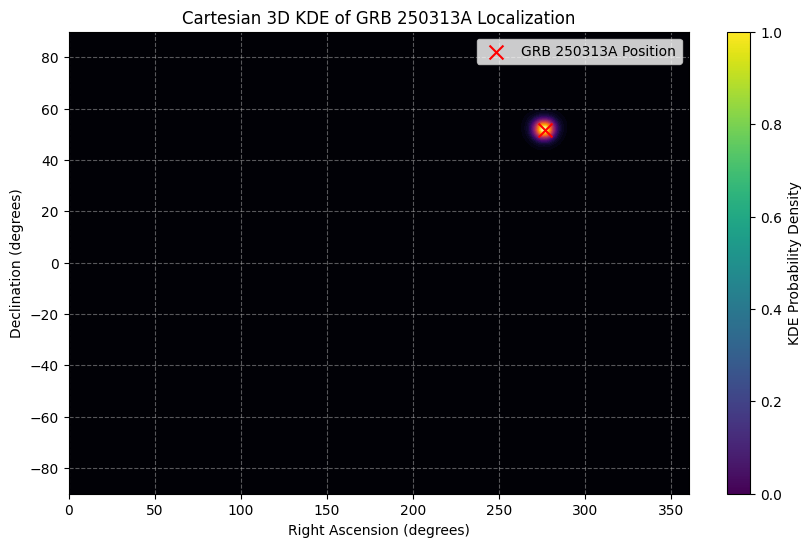

In [6]:
# Plot KDE result
plt.figure(figsize=(10, 6))
plt.contourf(ra_grid, dec_grid, density, cmap='inferno', levels=50)
# add the scatter plot of RA = 276.4, Dec = 51.8
plt.scatter(276.4, 51.8, color='red', marker='x', s=100, label='GRB 250313A Position')
plt.legend()
plt.colorbar(label='KDE Probability Density')
plt.xlabel('Right Ascension (degrees)')
plt.ylabel('Declination (degrees)')
plt.title('Cartesian 3D KDE of GRB 250313A Localization')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()